In [20]:
import glob
from importlib import reload
import os
import sys
sys.path.append('..')

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy  
import numpy as np
import seaborn as sb
import xarray as xr

from src import processing as pr
reload(pr)

<module 'src.processing' from '/Users/geet/Documents/Repositories/Owned/goesdata/notebooks/../src/processing.py'>

In [141]:
file = "/Users/geet/Documents/Repositories/Owned/goesdata/Data/goes16/2023/06/07/ABI-L1b-RadF/13/C13/OR_ABI-L1b-RadF-M6C13_G16_s20231581330215_e20231581339535_c20231581339577.nc"

In [142]:
img = pr.Image(file)
extent = (-150,5,-18.5,18.5)

ds = img.subset_region_from_latlon_extents(extent, unit="degree")

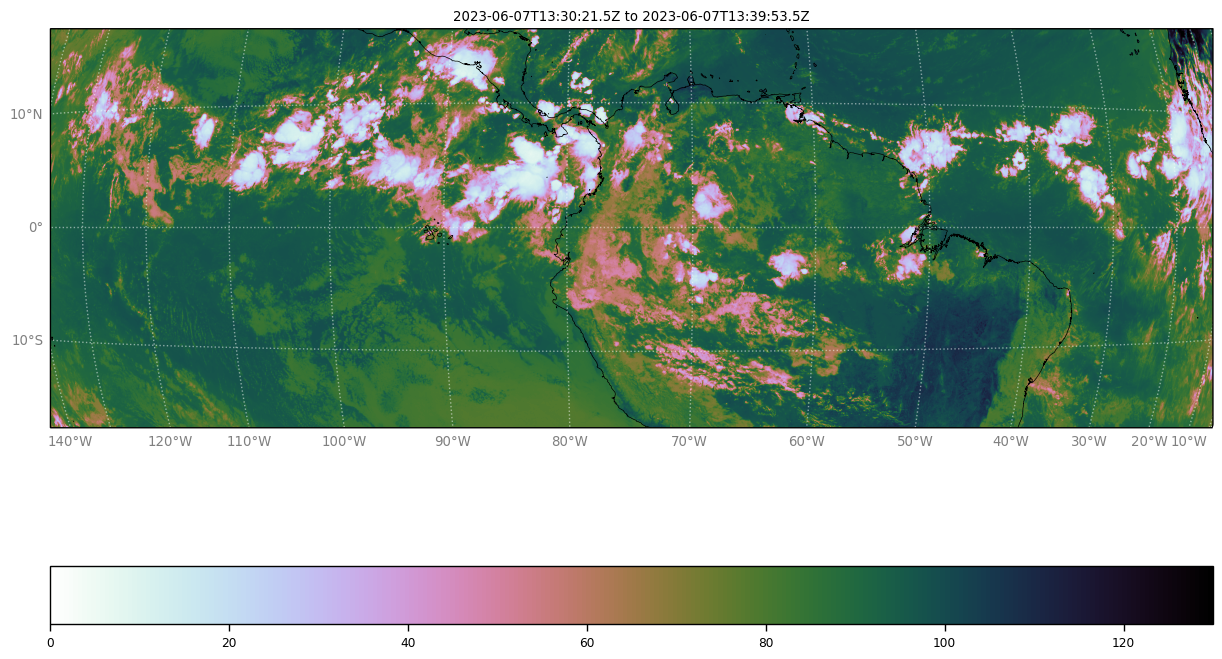

In [145]:
data = ds.metpy.parse_cf('Rad')
geostationary = data.metpy.cartopy_crs

# Sweep the ABI data from the x (north/south) and y (east/west) axes
x = data.x
y = data.y

# Use the geostationary projection to plot the image on a map
# This method streches the image across a map with the same projection and dimensions as the data
sb.set_context('paper')
fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=geostationary)

# Add the RGB True Color image to the figure. The data is in the same projection as the axis created
im = ax.imshow(ds.Rad, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()), transform=geostationary,cmap='cubehelix_r',vmin=0,vmax=130)
# ax.set_extent(extent, crs=ccrs.PlateCarree())
# Add coastlines and states
ax.coastlines(resolution='10m', color='black', linewidth=.5)

#Add title
plt.title(f"{ds.attrs['time_coverage_start']} to {ds.attrs['time_coverage_end']}")
plt.colorbar(im,orientation='horizontal')

# # # Draw grid.
gl = ax.gridlines(ccrs.PlateCarree(), linewidth = 1, color = 'w', alpha = 0.5, linestyle=':', draw_labels = True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'grey'}
gl.ylabel_style = {'color': 'grey'}

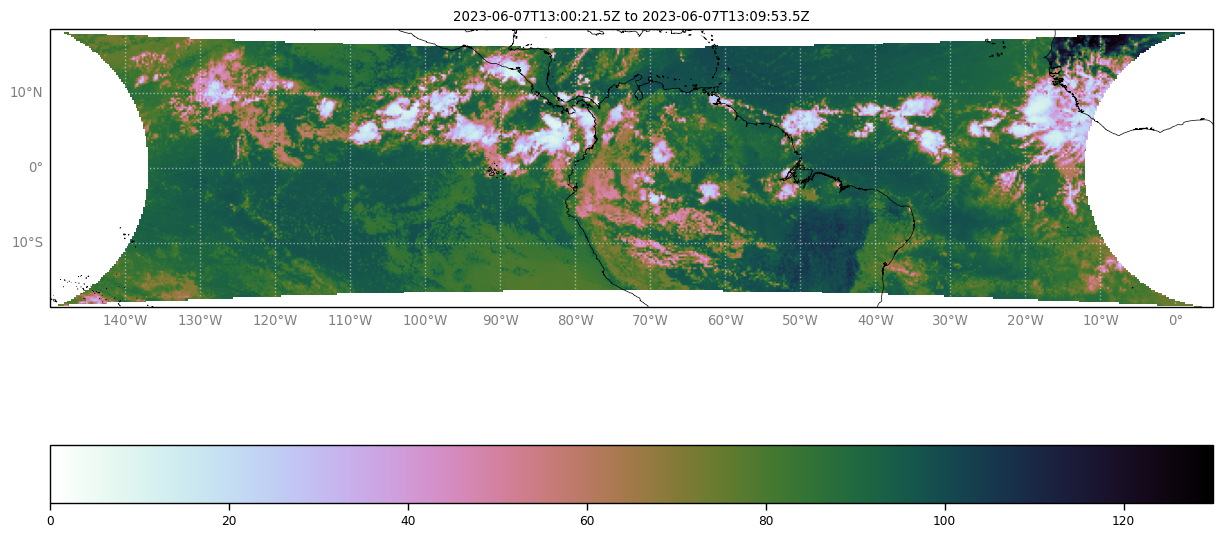

In [140]:
data = ds.metpy.parse_cf('Rad')
geostationary = data.metpy.cartopy_crs

# Sweep the ABI data from the x (north/south) and y (east/west) axes
x = data.x
y = data.y

# Use the geostationary projection to plot the image on a map
# This method streches the image across a map with the same projection and dimensions as the data
sb.set_context('paper')
fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add the RGB True Color image to the figure. The data is in the same projection as the axis created
im = ax.imshow(ds.Rad, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()), transform=geostationary,cmap='cubehelix_r',vmin=0,vmax=130)
ax.set_extent(extent, crs=ccrs.PlateCarree())
# Add coastlines and states
ax.coastlines(resolution='10m', color='black', linewidth=.5)

#Add title
plt.title(f"{ds.attrs['time_coverage_start']} to {ds.attrs['time_coverage_end']}")
plt.colorbar(im,orientation='horizontal')

# # # Draw grid.
gl = ax.gridlines(ccrs.PlateCarree(), linewidth = 1, color = 'w', alpha = 0.5, linestyle=':', draw_labels = True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'grey'}
gl.ylabel_style = {'color': 'grey'}

In [3]:
data_dir = "/Users/geet/Documents/Repositories/Owned/goesdata/Data/goes16/2023/06/07/ABI-L1b-RadF/13"
filename_prefix = "OR_ABI-L1b-RadF-M6"
filename_suffix = "_G16_s20231581300215_e20231581309523"
channels = ["C01","C02","C03"]
file = {}; ds = {}
for channel in channels:
    complete_filepath = glob.glob(os.path.join(data_dir,channel,filename_prefix+channel+filename_suffix+"*.nc"))
    if len(complete_filepath) > 1:
        print("More than one file found. Check what's going on.")
    else:
        file[channel] = complete_filepath[0]
        ds[channel] = xr.open_dataset(file[channel])

In [4]:
R = ds['C02']['Rad']
G = ds['C03']['Rad']
B = ds['C01']['Rad']

kappa_R = ds['C02']['kappa0']
kappa_G = ds['C03']['kappa0']
kappa_B = ds['C01']['kappa0']

#To convert radiance to reflectance, use formula:
#reflectance (ρf(υ)) = kappa factor(κ) * radiance (L(ν))
#Source: GOES-R Series Product Definition and User Guide (PUG) Volume 3, Revision 2.2, pages 27-28
R_ref = kappa_R * R
G_ref = kappa_G * G  
B_ref = kappa_B * B 

In [5]:
# Apply range limits for each channel. Reflectance values must be between 0 and 1.
R_ref = np.clip(R_ref, 0, 1)
G_ref = np.clip(G_ref, 0, 1)
B_ref = np.clip(B_ref, 0, 1)

In [6]:
# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
R = np.power(R_ref, 1/gamma)
G = np.power(G_ref, 1/gamma)
B = np.power(B_ref, 1/gamma)

In [7]:
# Define the rebin function that will be used to resample the band resolution
# Rebin function from https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [239]:
shape = [21696,21696]
shape[0],R.shape[0]//shape[0],shape[1],R.shape[1]//shape[1]

(21696, 1, 21696, 1)

In [13]:
#Resample the Red Band resolution
R_values = R.values
R_rescaled = rebin(R_values,[10848,10848])

In [14]:
R_rescaled.shape

(10848, 10848)

In [16]:
# GOES-R Series satellites do not have a channel in the visible green range. Band 3 is a NIR channel typically used to monitor vegetation.
# Calculate the "True" Green Band to serve as a green proxy for the RGB True Color image, using a fractional combination.
# Source: "Generation of GOES‐16 True Color Imagery without a Green Band" - https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018EA000379
G_true = 0.45*R_rescaled + 0.1*G + 0.45*B
G_true = np.clip(G_true, 0, 1)  # Apply band limits again, just in case.

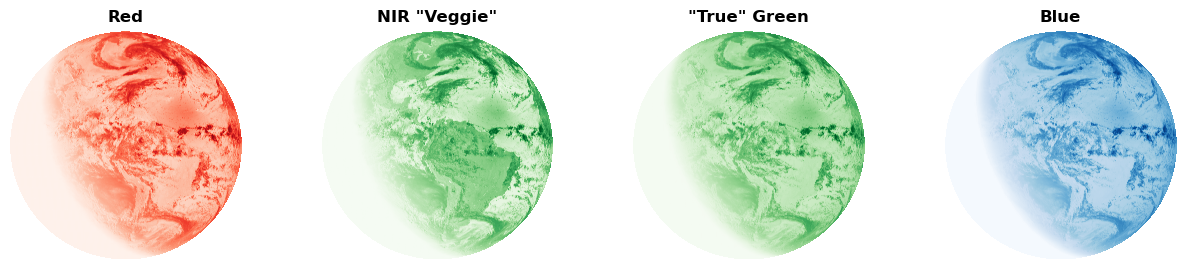

In [17]:
# Plot the four bands: Band 2 (Red), Band 3 (NIR "Veggie"), "True" Green, and Band 1 (Blue)
fig, ([ax1, ax2, ax3, ax4]) = plt.subplots(1, 4, figsize=(16, 3))

ax1.imshow(R_rescaled, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('Red', fontweight='bold')
ax1.axis('off')

ax2.imshow(G, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('NIR "Veggie"', fontweight='bold')
ax2.axis('off')

ax3.imshow(G_true, cmap='Greens', vmax=1, vmin=0)
ax3.set_title('"True" Green', fontweight='bold')
ax3.axis('off')

ax4.imshow(B, cmap='Blues', vmax=1, vmin=0)
ax4.set_title('Blue', fontweight='bold')
ax4.axis('off')

plt.subplots_adjust(wspace=.02)

(-0.5, 10847.5, 10847.5, -0.5)

/Users/geet/Documents/Repositories/Owned/goesdata/goesdata_env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


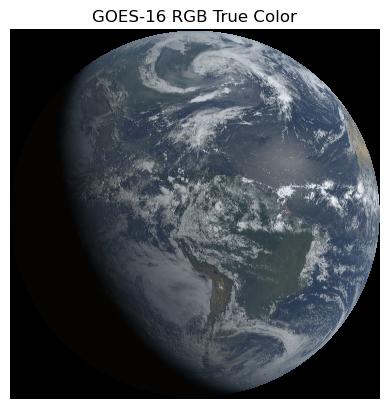

In [18]:
RGB = np.dstack([R_rescaled, G_true, B])

plt.imshow(RGB)
plt.title('GOES-16 RGB True Color')
plt.gca().axis('off');

In [22]:
data = ds['C01'].metpy.parse_cf('Rad')
geostationary = data.metpy.cartopy_crs

# Sweep the ABI data from the x (north/south) and y (east/west) axes
x = data.x
y = data.y

# Use the geostationary projection to plot the image on a map
# This method streches the image across a map with the same projection and dimensions as the data

fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=geostationary)

# Add the RGB True Color image to the figure. The data is in the same projection as the axis created
ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()), transform=geostationary)

# Add coastlines and states
ax.coastlines(resolution='50m', color='black', linewidth=.5)

#Add title
plt.title('GOES-16 RGB True Color', fontsize=15)
plt.savefig(f'GOES-16 RGB True Color - {filename_prefix}{filename_suffix}.png',dpi=300)
plt.close()

/Users/geet/Documents/Repositories/Owned/goesdata/goesdata_env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


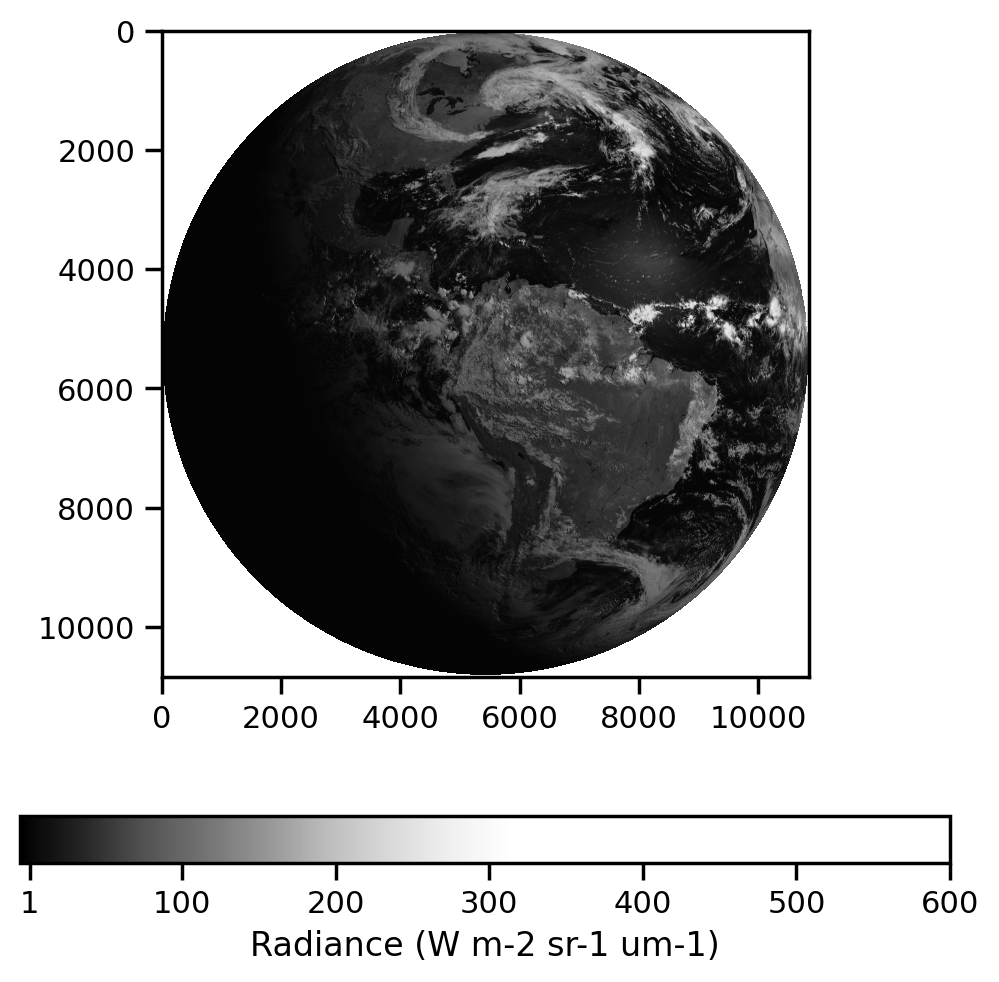

In [226]:
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(G['Rad'], cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')